Team ID: C16
Sem: 5
School: Computer Science and Engineering

Topic ID: YDMACP13
Title: IoT Malware Classification

Problem Statement: Classification of IoT Malware based on system calls into five different classes.

Team Members: 
Name: 
      - Shivam Ralli   USN: 01FE17BCS188 (Team Leader)
      - Shashi Prakash USN: 01FE17BCS184
      - Sagar Hotapeti USN: 01FE17BCS163
      - Ayush Nalavade USN: 01FE16BCS048

In [30]:
import pandas as pd
import glob 
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Why Creating?

Since all the data is in .seq format, it's unformatted and would be difficult to comprehend and clean. 
Thus, we'd be creating a csv to form inferences from this and performing the necessary data exploration activites on this. 

# Defining the train dataset:
    The method used would be to store all the file names present in the train folder and store it in a list.
    Opening all the files in the list and then storing all of the values in an empty dataframe, creating both train    and test in that order

In [2]:
#The function to read files and append in the dataframe
def filesdf(sequence_list):
    final_df = pd.DataFrame()
    for sequence_file in sequence_list:
        temp_df = pd.DataFrame(pd.read_csv(sequence_file, delimiter='EXIT\n', header=None))
        final_df=final_df.append(pd.Series(' '.join(temp_df[0].values)), ignore_index=True)
    return final_df

Creating the list for the train dataframe:

In [3]:
sequence_list = glob.glob("TRAIN/*.seq")
sequence_list.sort()

In [4]:
train_df = filesdf(sequence_list)
train_df.columns=['Commands']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


Since the train dataset is required to have the labels, i.e., the classification value of the Malware, the malware value _based_ on the command concatenated to the final dataframe.

In [5]:
label_values= pd.DataFrame(pd.read_csv('CDMC2019Task2Train.label', sep=',', header=None))
label_values.columns=['Commands', 'malware_value']


In [6]:
train_df['malware_value'] = label_values['malware_value']


In [7]:
train_df.head()

Commands  malware_value
0  execve ioctl ioctl prctl gettimeofday getpid g...              2
1  execve ioctl ioctl time getpid time getpid soc...              2
2  execve ioctl ioctl prctl time getpid time getp...              2
3  execve ioctl ioctl time getpid time getpid soc...              2
4  execve ioctl ioctl prctl time getpid time getp...              2

# Doing the same for the test dataset:

In [8]:
sequence_list = glob.glob("TEST/*.seq")
sequence_list.sort()

In [9]:
test_df = filesdf(sequence_list)
test_df.columns=['Commands']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [10]:
test_df.head()

Commands
0  execve uname brk brk set_tls set_tid_address s...
1  execve socket setsockopt fcntl fcntl bind list...
2  execve ioctl ioctl prctl time getpid time getp...
3  execve ioctl ioctl access geteuid prctl time g...
4  execve ioctl ioctl access geteuid prctl time g...

## Storing both the dataframes into csv files for ease of use:

In [11]:
train_df.to_csv('cdmc_task2 train_df.csv')
test_df.to_csv('cdmc_task2 test_df.csv')

In [12]:
%autosave 1

Autosaving every 1 seconds


# EDA

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import json
from IPython.display import HTML
from  altair.vega import v5
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.offline as py
import plotly.tools as tls
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import palettable
init_notebook_mode(connected=True)  
plt.style.use('ggplot')

import plotly.figure_factory as ff

## Driver functions:

In [2]:
##-----------------------------------------------------------
# This whole section 
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )



HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>")))

In [3]:

def word_cloud(df, pixwidth=720, pixheight=450, column="index", counts="count"):
    data= [dict(name="dataset", values=df.to_dict(orient="records"))]
    wordcloud = {
        "$schema": "https://vega.github.io/schema/vega/v5.json",
        "width": pixwidth,
        "height": pixheight,
        "padding": 0,
        "title": "Hover to see number of occureances from all the sequences",
        "data": data
    }
    scale = dict(
        name="color",
        type="ordinal",
        range=["cadetblue", "royalblue", "steelblue", "navy", "teal"]
    )
    mark = {
        "type":"text",
        "from":dict(data="dataset"),
        "encode":dict(
            enter=dict(
                text=dict(field=column),
                align=dict(value="center"),
                baseline=dict(value="alphabetic"),
                fill=dict(scale="color", field=column),
                tooltip=dict(signal="datum.count + ' occurrances'")
            )
        ),
        "transform": [{
            "type": "wordcloud",
            "text": dict(field=column),
            "size": [pixwidth, pixheight],
            "font": "Helvetica Neue, Arial",
            "fontSize": dict(field="datum.{}".format(counts)),
            "fontSizeRange": [10, 60],
            "padding": 2
        }]
    }
    wordcloud["scales"] = [scale]
    wordcloud["marks"] = [mark]
    
    return wordcloud



In [4]:
def pie_plot(labels, values, colors, title):
    fig = {
      "data": [
        {
          "values": values,
          "labels": labels,
          "domain": {"x": [0, .48]},
          "name": "Job Type",
          "sort": False,
          "marker": {'colors': colors},
          "textinfo":"percent+label+value",
          "textfont": {'color': '#FFFFFF', 'size': 10},
          "hole": .6,
          "type": "pie"
        } ],
        "layout": {
            "title":title,
            "annotations": [
                {
                    "font": {
                        "size": 25,

                    },
                    "showarrow": False,
                    "text": ""

                }
            ]
        }
    }
    return fig


def distplot(df):
    return ff.create_distplot([df['length']], ['length'], bin_size=10).show()

# Basic data exploration:

In [5]:
df = pd.DataFrame(pd.read_csv('CDMC2019 Task2 Df.csv'))

In [6]:
df.columns=['todrop', 'Commands', 'malware_value']
df.drop('todrop', axis=1, inplace=True)


In [7]:
df.head()

Commands  malware_value
0  execve ioctl ioctl prctl gettimeofday getpid g...              2
1  execve ioctl ioctl time getpid time getpid soc...              2
2  execve ioctl ioctl prctl time getpid time getp...              2
3  execve ioctl ioctl time getpid time getpid soc...              2
4  execve ioctl ioctl prctl time getpid time getp...              2

Adding the length of the words in the dataframe:

In [8]:
df['length'] = df.Commands.apply(lambda x: len(str(x).split()))

In [9]:
set(df.malware_value)

{1, 2, 3, 4, 5}

In [10]:
df.describe()

malware_value         length
count    4167.000000    4167.000000
mean        1.864171    9301.065515
std         1.008976   17924.083490
min         1.000000      51.000000
25%         1.000000     435.000000
50%         2.000000     543.000000
75%         2.000000   11651.000000
max         5.000000  189123.000000

Finding the counts of occurances of all the malware_types

In [11]:
from palettable.colorbrewer.qualitative import Dark2_5

In [12]:
Dark2_5.hex_colors

['#1B9E77', '#D95F02', '#7570B3', '#E7298A', '#66A61E']

In [13]:
value_counts = df['malware_value'].value_counts()
labels = value_counts.index.tolist()
py.iplot(pie_plot(labels, value_counts, ['#1B9E77', '#D95F02', '#7570B3', '#E7298A', '#66A61E'], "Malware Types"))

The counts stand as follows:
- 1: 1541 instances out of 4167
- 2: 2265 instances out of 4167
- 3: 34 instances out of 4167
- 4: 40 instances out of 4167
- 5: 287 instances out of 4167

From the above pie plot, we can see that the data is heavily imbalanced. Solving class imbalance could be a necessary step for getting accurate classifications. 
We could:
- Resample the data to reduce imbalance, either upsampling minority classes of downsampling the majority ones
- Use tensorflow smote method to create more instances for the imbalance

Thus, since the values are in range 1-5, let's build wordclouds for them to find some similarity in the word occurances

# Creating wordclouds for Classification values 1-5:

In [14]:
#Function for wordcloud driver:
from collections import defaultdict
def wordcloud_create(df):
    corpus = df.Commands.values.tolist()
    final = defaultdict(int) #Declaring an empty dictionary for count (Saves ram usage)
    for words in corpus:
        for word in words.split():
             final[word]+=1
                
                
    corpus = pd.Series(final) #Creating a dataframe from the final default dict
    return render(word_cloud(corpus.to_frame(name="count").reset_index(), pixheight=600, pixwidth=900))

## Wordcloud for Malware_value 1

In [15]:
df_1 = df[df.malware_value==1]

wordcloud_create(df_1)

From the given worldcloud, we can observe that the commands have instances as follows:
- recvfrom: 9091549 instances
- sendto: 9083794 instances

Thus, we can form a vague idea that the first malware classification must be for socket tasks which involve the malware to be focused around send and recv of data between them.

## Wordcloud for Malware_value 2

In [16]:
df_2 = df[df.malware_value==2]

wordcloud_create(df_2)

From the given worldcloud, we can observe that the commands have instances as follows:
- getsockopt: 1241292 instances
- newselect: 1253044 instances

Thus, we can form a vague idea that the second malware classification must be for socket tasks which involve the creation of socket and it's underlying conncections. 

## Wordcloud for Malware_value 3

In [17]:
df_3 = df[df.malware_value==3]

wordcloud_create(df_3)

From the given worldcloud, we can observe that the commands have instances as follows:
- clock_gettime: 170988 instances
- gettimeofday: 85807 instances

Thus, we can form a vague idea that the third malware classification must be for  tasks which involve the malware to be focused around time based data. Also, as the number of general instances of the third malware is marginally less than the first and second, it could be considered that the instances are high for extremely less instances of the third malware.

## Wordcloud for Malware_value 4

In [18]:
df_4 = df[df.malware_value==4]

wordcloud_create(df_4)

From the given worldcloud, we can observe that the commands have instances as follows:
- rt_sigaction: 6649 instances
- rt_sigprocmask: 5757 instances

Thus, we can form a vague idea that the fourth malware classification must generally be focused for masking the calling threads or actions on such threads. The number of instances are in range with the overall number of occurances for the fourth malware in the data.

## Wordcloud for Malware_value 5

In [19]:
df_5 = df[df.malware_value==5]

wordcloud_create(df_5)

From the given worldcloud, we can observe that the commands have instances as follows:
- close: 164358 instances
- open: 108164 instances

Thus, we can form a vague idea that the fifth malware classification must be for socket tasks which involve the malware to be focused around the opening and closing of sockets/files, with secondary processes around time of day and masks for the threads.

### To get an even more extensive idea over the wordclouds, plotting the distribution plot for the data based on length of words:

### Malware: 1

In [20]:
df_1 = df[df.malware_value==1]
distplot(df_1)

For the first malware, it can be observed that most of the values lie in the range of 0-24k of words in length, 
with numerous outliers, the maximum going up to 188.7449k in length.

The sheer peaks of the distplot lie around tge range of 0-2.5k

### Malware: 2

In [21]:
df_2 = df[df.malware_value==2]
distplot(df_2)

Although the second malware has the highest number of occurances amongst the rest of the malwares, the general length of words for such would lie around the range of 0-600 words, with some stretching out till 5k, and the outlier having the maximum of 166k. 

### Malware 3

In [22]:
df_3 = df[df.malware_value==3]
distplot(df_3)

The third malware, with the first amongst the less instances, has the range of 5k-27k in general, with the outlier at 45k 

### Malware 4:

In [23]:
df_4 = df[df.malware_value==4]
distplot(df_4)

Malware 4 is perhaps the one with the least amount of words, with it peaking around 52 words, with much higher density around a 1000 words and the outliers around 8k range

### Malware 5:

In [24]:
df_5 = df[df.malware_value==5]
distplot(df_5)

The max occurred value for the fifth malware is around 400 words, with a wider cluster of arrangement between 2-4k words. The outlier stands at 16k words. 


# Preprocessing

In [40]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [2]:
pd.set_option('display.max_columns', 50)

In [4]:
train = pd.read_csv('cdmc_task2 train_df.csv')
train.drop('Unnamed: 0' , axis =  1 ,inplace = True)
train.index = range(1,len(train) + 1)
train.head(10)

Commands  malware_value
1   execve ioctl ioctl prctl gettimeofday getpid g...              2
2   execve ioctl ioctl time getpid time getpid soc...              2
3   execve ioctl ioctl prctl time getpid time getp...              2
4   execve ioctl ioctl time getpid time getpid soc...              2
5   execve ioctl ioctl prctl time getpid time getp...              2
6   execve ioctl ioctl prctl gettimeofday getpid g...              2
7   execve ioctl ioctl time getpid time getpid soc...              2
8   execve ioctl ioctl prctl gettimeofday getpid g...              2
9   execve ioctl ioctl prctl gettimeofday getpid g...              2
10  execve ioctl ioctl prctl time getpid time getp...              2

## Adding new features:

In [5]:
train['length'] = train.Commands.apply(lambda x: len(str(x).split()))

In [6]:
train.corr()

malware_value    length
malware_value       1.000000 -0.248536
length             -0.248536  1.000000

## Test train split:

In [60]:
X , y  = train.drop(['malware_value'], axis=1).to_numpy() , train.malware_value.to_numpy()

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X , y,test_size=.2,random_state=42)

# Resampling Theory:

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

## Undersampling the train and test to the class with least numbers:

In [62]:
train_under_df=pd.concat([pd.DataFrame(X_train), pd.Series(y_train)],axis=1, ignore_index= True)
train_under_df.columns=['Commands', 'Length', 'malware_class']
train_under_df.head()

Commands Length  malware_class
0  execve ioctl ioctl prctl time getpid time getp...    546              2
1  execve ioctl ioctl access geteuid prctl time g...  37873              1
2  execve ioctl ioctl time getpid getppid times p...    843              1
3  execve brk brk set_tls ioctl ioctl rt_sigprocm...   7681              1
4  execve brk brk set_tls ioctl ioctl rt_sigprocm...   7687              1

In [63]:
pd.DataFrame(train_under_df.malware_class.value_counts())

malware_class
2           1799
1           1228
5            246
4             32
3             28

#### Since the least number of classes are 27, we will undersample all of the classes down to the length of the 4th Class, thus undersampling it.

In [64]:
# Generating inividual dataframes for each malware class:

Class1= train_under_df[train_under_df.malware_class==1]
Class2= train_under_df[train_under_df.malware_class==2]
Class3= train_under_df[train_under_df.malware_class==3]
Class4= train_under_df[train_under_df.malware_class==4]
Class5= train_under_df[train_under_df.malware_class==5]

In [65]:
downsampled = pd.DataFrame()

In [69]:
Classes= [Class1, Class2, Class3, Class5]
for i in Classes:
    i = resample(i,
                replace = False, # sample without replacement
                n_samples = len(Class3), # match minority n
                random_state = 27) # reproducible results
    downsampled = pd.concat([downsampled,i])
    
# combine minority and downsampled majority
downsampled = pd.concat([downsampled, Class4])



In [70]:
downsampled.head()

Commands Length  malware_class
2748  execve mmap cacheflush readlink cacheflush mma...  32354              1
1227  execve unlink rt_sigprocmask rt_sigaction rt_s...  20464              1
1419  execve brk brk set_tls ioctl ioctl rt_sigprocm...   9567              1
640   execve mmap cacheflush readlink cacheflush mma...  51098              1
2149  execve ioctl ioctl geteuid write write time ge...  42713              1

In [71]:
y_train_down = downsampled.malware_class

## OverSampling the train and test to the class with the most numbers:

In [72]:
train_over_df=pd.concat([pd.DataFrame(X_train), pd.Series(y_train)],axis=1, ignore_index= True)
train_over_df.columns=['Commands', 'Length', 'malware_class']
train_over_df.head()

Commands Length  malware_class
0  execve ioctl ioctl prctl time getpid time getp...    546              2
1  execve ioctl ioctl access geteuid prctl time g...  37873              1
2  execve ioctl ioctl time getpid getppid times p...    843              1
3  execve brk brk set_tls ioctl ioctl rt_sigprocm...   7681              1
4  execve brk brk set_tls ioctl ioctl rt_sigprocm...   7687              1

In [73]:
pd.DataFrame(train_over_df.malware_class.value_counts())

malware_class
2           1799
1           1228
5            246
4             32
3             28

#### Since the max number of classes are 1799, we will oversample all of the classes up to the length of the 2th Class, thus oversampling it.

In [74]:
# Generating inividual dataframes for each malware class:

Class1= train_over_df[train_over_df.malware_class==1]
Class2= train_over_df[train_over_df.malware_class==2]
Class3= train_over_df[train_over_df.malware_class==3]
Class4= train_over_df[train_over_df.malware_class==4]
Class5= train_over_df[train_over_df.malware_class==5]

In [75]:
upsampled = pd.DataFrame()

In [76]:
Classes= [Class1, Class4, Class3, Class5]
for i in Classes:
    i = resample(i,
                replace = True, # sample with replacement
                n_samples = len(Class2), # match majority n
                random_state = 27) # reproducible results

    upsampled = pd.concat([upsampled,i])

# combine minority and upsampled majority
upsampled = pd.concat([upsampled, Class2])




In [77]:
upsampled.head()

Commands Length  malware_class
2895  execve open mmap2 mmap2 cacheflush mprotect re...    295              1
1444  execve ioctl ioctl access geteuid prctl time g...  13148              1
2062  execve brk brk set_tls ioctl ioctl access gete...  44986              1
2901  execve ioctl ioctl prctl write write fork exit...    446              1
356   execve ioctl ioctl access geteuid prctl time g...    232              1

In [78]:
y_train_up = upsampled.malware_class

## TF-IDF and Feature Union

In [79]:
from sklearn.model_selection import KFold
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_log_error
import eli5
from tqdm import tqdm_notebook

In [80]:
# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
def get_features(df):
    df[['Commands', 'Length']]=df[['Commands', 'Length']].astype(str)
    default_preprocessor = CountVectorizer().build_preprocessor()
    def build_preprocessor(field):
        field_idx = list(df.columns).index(field)
        return lambda x: default_preprocessor(x[field_idx])

    vectorizer = FeatureUnion([
        ('Length', CountVectorizer(
            token_pattern='\d+', 
            preprocessor=build_preprocessor('Length'))),
        ('Commands', TfidfVectorizer(
            ngram_range=(2, 5) , sublinear_tf= True,
            preprocessor=build_preprocessor('Commands'), )),
    ])
    x_train_fit = vectorizer.fit(df[['Commands', 'Length']].values)
    x_train_trans = vectorizer.transform(df[['Commands', 'Length']].values)
    
    return vectorizer, x_train_fit, x_train_trans

In [81]:
without_train = train_under_df

In [82]:
vectorizer_without, x_trainfit_without, x_train_trans_without = get_features(without_train)
vectorizer_under, x_trainfit_under, x_train_trans_under = get_features(downsampled)
vectorizer_up, x_trainfit_up, x_train_trans_up = get_features(upsampled)


## Checking for cross validation scores:

Three different kinds of models have been considered: 
- Linear Model: Logistic Regression
- Ensemble Model: LGBM Classification
- Instance based Model: K Nearest Neighbors

In [31]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [32]:
models = [LogisticRegression(), LGBMClassifier(), KNeighborsClassifier()]

In [33]:
def cv_df_formation(x_val, y_val):
    from sklearn.model_selection import cross_val_score
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))

    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, x_val, y_val, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    return cv_df

In [34]:
cv_df_without = cv_df_formation(x_train_trans_without, y_train)

In [35]:
cv_df_without

model_name  fold_idx  accuracy
0     LogisticRegression         0  0.970990
1     LogisticRegression         1  0.958974
2     LogisticRegression         2  0.951973
3     LogisticRegression         3  0.982788
4     LogisticRegression         4  0.977625
5         LGBMClassifier         0  0.979522
6         LGBMClassifier         1  0.981197
7         LGBMClassifier         2  0.970840
8         LGBMClassifier         3  0.989673
9         LGBMClassifier         4  0.984509
10  KNeighborsClassifier         0  0.976109
11  KNeighborsClassifier         1  0.952137
12  KNeighborsClassifier         2  0.951973
13  KNeighborsClassifier         3  0.963855
14  KNeighborsClassifier         4  0.962134

In [36]:
cv_df_under = cv_df_formation(x_train_trans_under, y_train_down)

In [37]:
cv_df_under

model_name  fold_idx  accuracy
0     LogisticRegression         0  0.981818
1     LogisticRegression         1  1.000000
2     LogisticRegression         2  0.981818
3     LogisticRegression         3  1.000000
4     LogisticRegression         4  1.000000
5         LGBMClassifier         0  1.000000
6         LGBMClassifier         1  1.000000
7         LGBMClassifier         2  1.000000
8         LGBMClassifier         3  1.000000
9         LGBMClassifier         4  1.000000
10  KNeighborsClassifier         0  0.945455
11  KNeighborsClassifier         1  0.981818
12  KNeighborsClassifier         2  0.963636
13  KNeighborsClassifier         3  0.963636
14  KNeighborsClassifier         4  1.000000

In [38]:
cv_df_over = cv_df_formation(x_train_trans_up, y_train_up)

In [39]:
cv_df_over

model_name  fold_idx  accuracy
0     LogisticRegression         0  0.988013
1     LogisticRegression         1  0.983544
2     LogisticRegression         2  0.987975
3     LogisticRegression         3  0.992405
4     LogisticRegression         4  0.991139
5         LGBMClassifier         0  0.995584
6         LGBMClassifier         1  0.991772
7         LGBMClassifier         2  0.993038
8         LGBMClassifier         3  0.998734
9         LGBMClassifier         4  0.996835
10  KNeighborsClassifier         0  0.988644
11  KNeighborsClassifier         1  0.981646
12  KNeighborsClassifier         2  0.985443
13  KNeighborsClassifier         3  0.991139
14  KNeighborsClassifier         4  0.987975

## Bias Variance:

In [48]:
bias_train = train.drop("malware_value", axis=1)
bias_y_train = train.malware_value

In [51]:
bias_train.columns = ['Commands', 'Length']

In [52]:
vectorizer_bias, x_trainfit_bias, x_train_trans_bias = get_features(bias_train)

In [53]:
test_perc_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [55]:
estimator=LGBMClassifier()
cv=5
n_jobs=-1
train_sizes, train_scores, test_scores = learning_curve(estimator,x_train_trans_bias, bias_y_train, cv=cv, n_jobs=n_jobs, train_sizes=test_perc_list)



In [56]:
def get_mean(arr):
    final= []
    for i in range(arr.shape[0]):
        final.append(arr[i].mean())
    return final

In [57]:
trainFinal,testFinal = get_mean(train_scores),get_mean(test_scores)

In [58]:
fig=go.Figure()
x,y,z = test_perc_list,trainFinal,testFinal
fig.add_trace(go.Scatter(x=x , y=y , name = 'Train Score',line_shape = 'linear'))
fig.add_trace(go.Scatter(x=x , y=z , name = 'Test Score',line_shape = 'linear'))
fig.update_layout(title_text = 'Bais Variance TradeOff')
fig.update_xaxes(title_text='Train Size' , showgrid = False)
fig.update_yaxes(title_text='Accuracy' , showgrid = False)
fig.show()

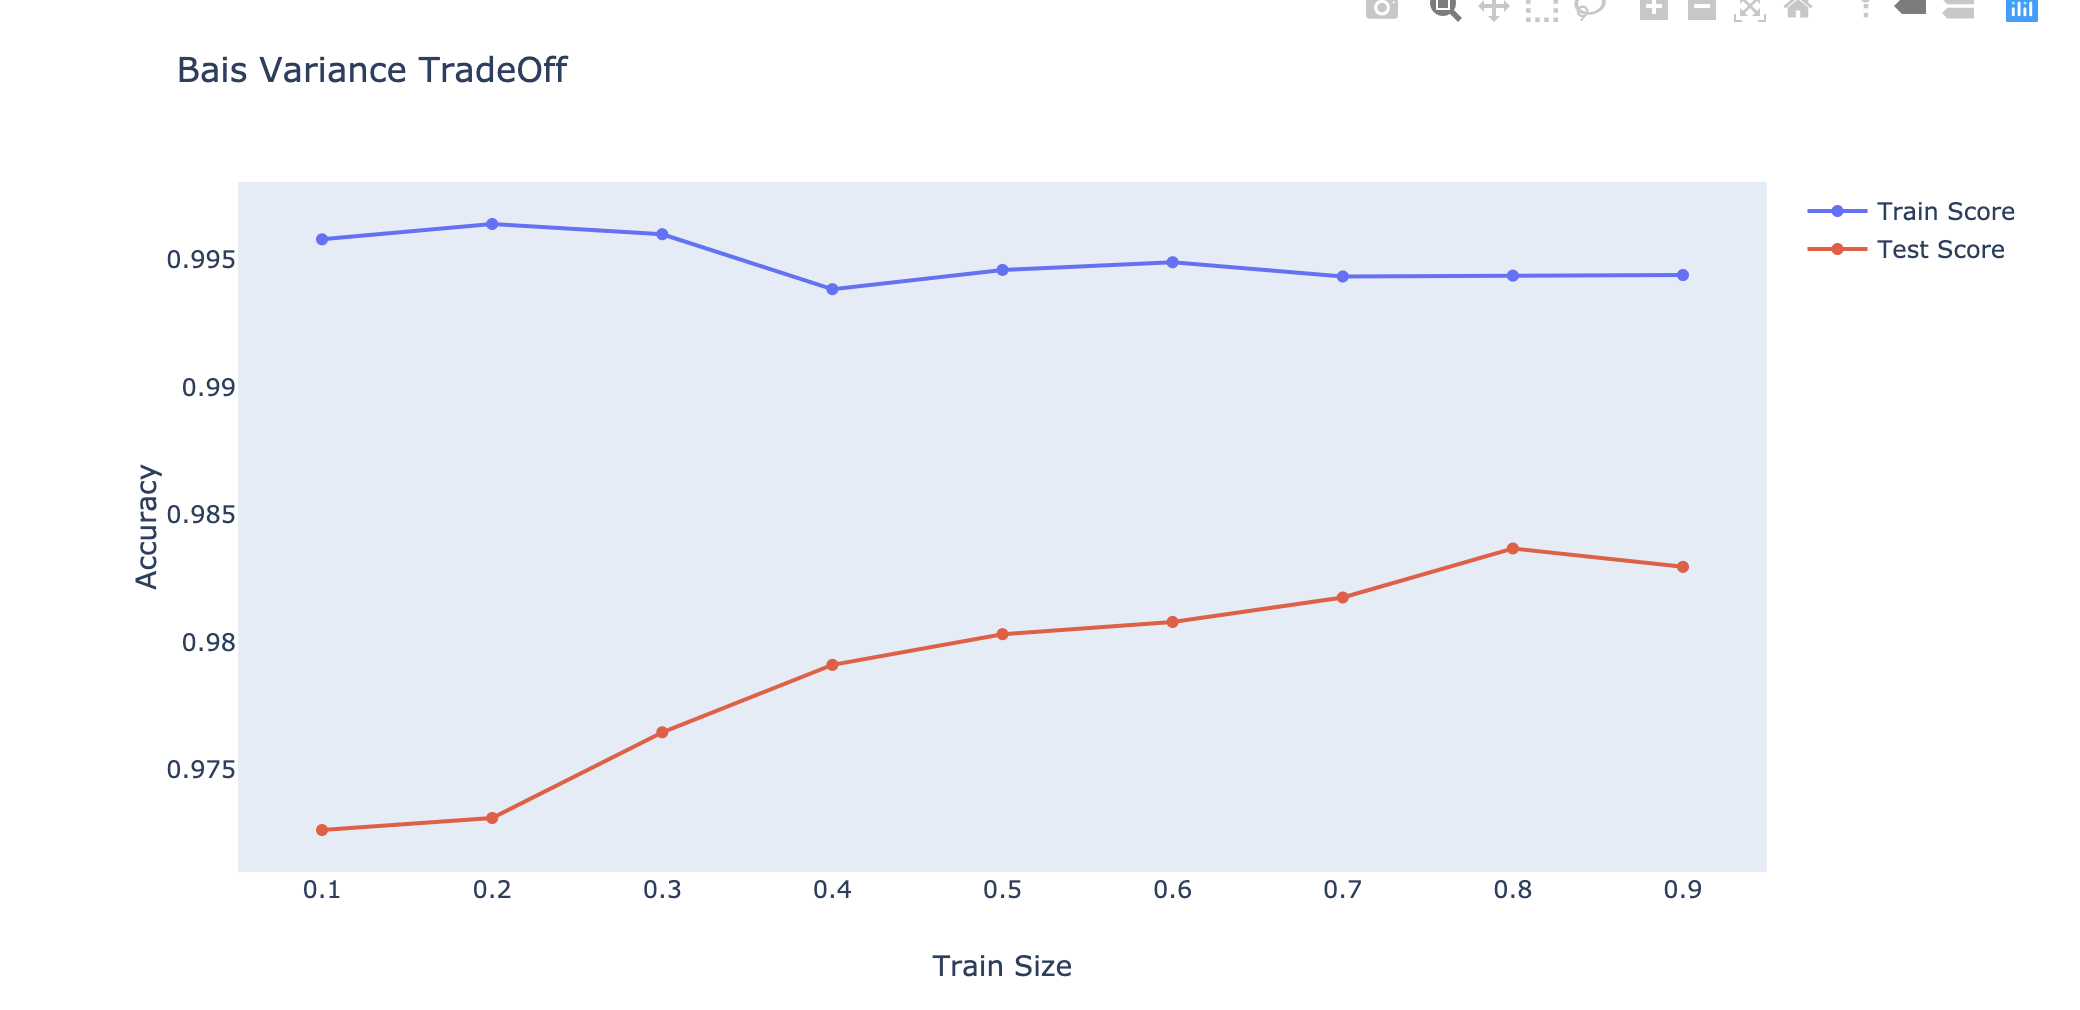

## Applying LGBM on X_Test for all three. (Without parameter tuning)


In [83]:
from lightgbm import LGBMClassifier

In [84]:
model_without, model_down, model_up = LGBMClassifier(), LGBMClassifier(), LGBMClassifier()

In [85]:
model_without.fit(x_train_trans_without,y_train)
model_down.fit(x_train_trans_under, y_train_down)
model_up.fit(x_train_trans_up, y_train_up)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Turning the X_test into a dataframe so that it can be transformed after being coverted to str

In [86]:
X_test = pd.DataFrame(X_test)
X_test.columns = ['Commands', 'Length']
X_test[['Commands', 'Length']]= X_test[['Commands', 'Length']].astype(str)

In [87]:
X_test_trans = x_trainfit_without.transform(X_test[['Commands', 'Length']].values)

In [88]:
y_pred_without = model_without.predict(x_trainfit_without.transform(X_test[['Commands', 'Length']].values))
y_pred_down = model_down.predict(x_trainfit_under.transform(X_test.values))
y_pred_up = model_up.predict(x_trainfit_up.transform(X_test.values))

### Accuracy Metrics for each malware_class

In [89]:
from sklearn import metrics

**Metrics for model without resampling**

In [90]:
labels_list = ['1','2','3','4', '5']
print(metrics.classification_report(y_test, y_pred_without,target_names= labels_list))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       313
           2       0.98      0.99      0.99       466
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        41

    accuracy                           0.98       834
   macro avg       0.99      0.99      0.99       834
weighted avg       0.98      0.98      0.98       834



**Metrics for model with downsampling**

In [91]:
print(metrics.classification_report(y_test, y_pred_down,target_names= labels_list))

              precision    recall  f1-score   support

           1       0.91      0.90      0.90       313
           2       0.94      0.93      0.94       466
           3       1.00      1.00      1.00         6
           4       0.44      1.00      0.62         8
           5       1.00      1.00      1.00        41

    accuracy                           0.92       834
   macro avg       0.86      0.97      0.89       834
weighted avg       0.93      0.92      0.93       834



**Metrics for model with upsampling**

In [92]:
print(metrics.classification_report(y_test, y_pred_up,target_names= labels_list))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       313
           2       0.98      0.99      0.99       466
           3       1.00      1.00      1.00         6
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00        41

    accuracy                           0.98       834
   macro avg       0.99      0.97      0.98       834
weighted avg       0.98      0.98      0.98       834



### Significance of the metric scores:

Precision: True Positives + False Positives, tells us what proportion of malware we classified actually had that malware.

Recall: True Positives + False Negatives, Tells us what proportion of malware we classified had actually been detected by the algorithm

F-1 score: The balance between precision and recall, given by the formula: 2*(Precision * Recall)/(Precision+Recall)

## Finding the weights of the classes of each model:

#### Model Without any resampling:

In [93]:
eli5.show_weights(model_without, vec=vectorizer_without, top=10, feature_filter=lambda x: x != '<BIAS>')

In [94]:
eli5.show_prediction(model_without, doc=without_train.values[3], vec=vectorizer_without)

#### Model with downsampling:

In [95]:
eli5.show_weights(model_down, vec=vectorizer_under, top=15, feature_filter=lambda x: x != '<BIAS>')

In [96]:
eli5.show_prediction(model_down, doc=downsampled.values[5], vec=vectorizer_under)


#### Model with upsampling:

In [47]:
eli5.show_weights(model_up, vec=vectorizer_up, top=10, feature_filter=lambda x: x != '<BIAS>')

KeyboardInterrupt: 

## Applying Hyperopt.

## What is hyperopt?

Since we've already picked our model in the last stage, we will be going for parameter tuning. 
Usually, the most popular methods involve GridSearchCV and RandomSearchCV.

Hyperparameter tuning is an essential part of building a model, since it fine tunes our required model to the data provided. 

### One of the basic methods is GridSearchCV.
This approach just trying all available parameters' combinations 1 by 1 and choose the one with the best cross validation results.

This approach has several drawbacks:

- It is very slow - you just **try ALL combinations of ALL parameters**  and it takes a lot of time. Any additional parameter to variate multiply the number of iterations you need to complete. Imagine that you add to the parameter grid a new parameter with 10 possible values, this parameter can turn out to be meaningless but the computational time will be increased 10 times.
- It can work only with discrete values. If the global optimum is on n_estimators=550, but you are doing GridSearchCV from 100 to 1000 with step 100, you will never reach the optimal point.
- You need to know / guess the approximate localization of the optimum to complete the search in a reasonable time.


### The second method would be RandomSearchCV:

Random Search is on average more effective than Grid Search.

Main advantages:

- Don't spend time on meaningless parameters. **On every step random search variate all parameters.**
- On average finds ~optimal parameters much faster than Grid search.
- It is not limited by grid when we optimize continuous parameters.

Disadvantages:

- It may not find the global optimal parameter on a grid.
- All steps are independent. On every particular step it does not use any information about the results gathered so far. But they can be useful. For example, if we found a good solution it can be useful to search around it to find even better point comparing to looking at other completely random variants.

### Hyperopt:

#### TPE: Tree structured Parsen Estimator:

TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step. Generally this types of algorithms works like this:

- Generate random initial point ${x^*}$
- Calculate ${F(x^*)}$
- Using the history of trials try to build the conditional probability model $P(F | x)$
- Choose ${x_i}$ that according to the $P(F | x)$ will most probably result in better ${F(x_i)}$
- Compute the real value of the ${F(x_i)}$
- Repeat steps 3-5 until one of the stop criteria is satisfied, for example i > max_eval

#### Simulated Anneal

Simulated anneal minimizes function ${F(x)}$ (in case of hyperparameters optimization x - parameters, F() - cross validation score function) as follows:

- Generate random initial point ${x^*}$
- Calculate ${F(x^*)}$

- Generate ${x_i}$ randomly in some neighbourhood of ${x*}$

- Calculate ${F(x_i)}$
- Update ${x*}$ according to the rule:

- if ${F(x_i)}<={F(x^*)}: {x^*} = {x_i}$

- else: ${x^*} = {x_i}$ with probability $p=\exp\left(\dfrac{F({x^*})-F({x_i})}{T_i}\right)$

- where ${T_i}$, called temperature is constantly decreasing sequence

- Repeat steps 3-5 until one of the stop criteria is satisfied:

i > max_eval
${T_i} < {T_{min}}$
While ${T_i}$ is high, the algorithm performs a lot of exploration steps (similar to random search) as the probability to update ${x^*}$ is high even if ${F(x_i)}>{F(x^*)}$

But when T became lower, the algorithm focuses on exploitation - all ${x_i}$ are near one of the best solutions found so far.


**For the following models, Anneal based model for the hyperopt category would used. Usually, for most of the models, anneal tends to perform admirably higher, since it's based a little from the RandomSearch, while using probablites.**

In [49]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score

In [46]:
random_state=42
n_iter=100

num_folds=5
kf = KFold(n_splits=num_folds, random_state=random_state)

In [47]:

def gb_mse_cv_LGB(params, random_state=random_state, cv=kf, X=x_train_trans_without, y=y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
            'min_child_samples': int(params['min_child_samples']),
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'subsample_freq': int(params['subsample_freq']),
              'subsample': params['subsample']
              
             }
    
    # we use this params to create a new LGBM Regressor
    model = LGBMClassifier(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()

    return score



In [50]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 25, 1),
       'learning_rate': hp.loguniform('learning_rate',0 , 4),
       'num_leaves': hp.quniform('num_leaves', 11, 450,1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 40, 1),
      'reg_alpha': hp.loguniform('reg_alpha', 0, 4),
       'reg_lambda':hp.loguniform('reg_lambda', 0, 5),
      'subsample_freq': hp.quniform('subsample_freq', 2, 20, 1),
      'subsample': hp.quniform('subsample', 0, 1, 0.1)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv_LGB, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'],
                      num_leaves=int(best['num_leaves']), min_child_samples=int(best['min_child_samples']),
                         reg_lambda=best['reg_lambda'], reg_alpha=best['reg_alpha'], subsample=best['subsample'], 
                       subsample_freq=int(best['subsample_freq'])
                      )
model.fit(x_train_trans_without,y_train)
tpe_test_score=accuracy_score(y_test, model.predict(X_test_trans))
print(tpe_test_score)

100%|██████████| 100/100 [2:27:11<00:00, 88.32s/it, best loss: -0.983195681289504]  
0.9856115107913669


In [97]:
model = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08583748564200731,
               max_depth=11, min_child_samples=30, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=919, n_jobs=-1, num_leaves=60,
               objective=None, random_state=42, reg_alpha=1.5543843815592084,
               reg_lambda=6.263494698476247, silent=True,
               subsample=0.6000000000000001, subsample_for_bin=200000,
               subsample_freq=16)

In [98]:
model.fit(x_train_trans_without,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08583748564200731,
               max_depth=11, min_child_samples=30, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=919, n_jobs=-1, num_leaves=60,
               objective=None, random_state=42, reg_alpha=1.5543843815592084,
               reg_lambda=6.263494698476247, silent=True,
               subsample=0.6000000000000001, subsample_for_bin=200000,
               subsample_freq=16)

In [102]:
tpe_test_score=metrics.accuracy_score(y_test, model.predict(X_test_trans))
print(tpe_test_score)

0.989810551558753
